# pythonによるベイズ統計モデリング入門 ~ pyMCによるMCMCで線形回帰をやってみる ~

## はじめに
### 完全なデータ・ドリブンアプローチは正しいのか？もっと人間のノウハウをモデリングに活用する！
- 昨今のビッグデータ・機械学習は全ての規則（ルール）をデータから学習させる、というアプローチが中心かと思います
- しかし現実問題として、あらゆる事象に関するデータを網羅的にかつ大量に蓄積している状況は稀です
- そこで注目したいのが、**データ化はされていないが長年の経験から蓄積され人間の頭の中に存在するノウハウ（知識）**です
- これらのノウハウを用いることで、不十分なデータを補うことができる可能性があるのが、ベイズ統計（ベイズモデリング）です
- 全ての事象に対してデータ・ドリブンで取り組むアプローチの限界から改めてベイズ統計学が注目をされており、昨今、**ベイズ深層学習**や**ベイズ機械学習**といった言葉も登場してきています
- そこで本記事ではベイズ統計学の基礎をpythonのライブラリ（pyMCとpyro）を用いて解説をしてみます
- ベイズ統計学の概念は、初学者にとっては「理解」しづらいですが、実際のデータを用いて「利用」から入るとイメージが湧きやすいためです

---

## ベイズ統計学（基礎）
- ここでは最低限の考え方（イメージ）と基本定理だけ紹介します
- 正確・詳細なベイズ統計学の解説は分かりやすい書籍が世の中には沢山あるので、それらをご参照ください

### ベイズの考え方（イメージ）
#### 「結果」から「原因」を推論するのがベイズ統計学
- 通常、統計学の勉強を始める人は頻度論的な統計学から入門することが多いかと思いますが、これがベイズ統計学が分かりづらい原因の一つかと思います
- 頻度論的統計学では、母集団という真の値が「原因」としてあり、観測されるデータはその「結果」として捉えます
- 一方で、ベイズ統計学では観測されたデータ（結果）から母集団（原因）を推定します
- そのため、ベイズ統計学では、母集団を変数（観測されるデータに応じて変化する値・定数でない）として扱います

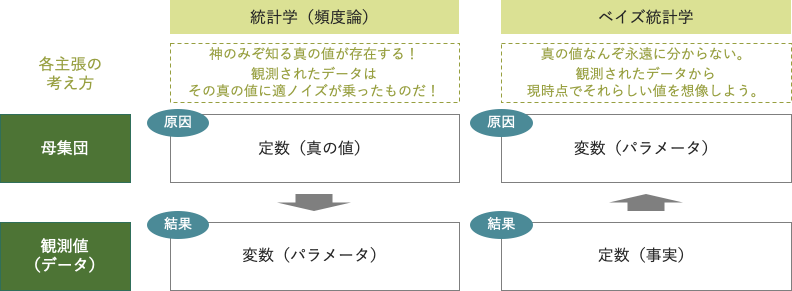

#### ベイズ統計学では、変数（パラーメータ）を主観で"仮決め"して、観測されたデータで修正（更新）
- 「原因」の変数（パラメータ）を推定する際に、ベイズ統計学では、「事前分布」と「事後分布」という概念を利用します
- 事前分布は、人間が既に知っている知識をもとに設定することができます（これが、ベイズ統計学を利用することで、人間の頭の中のノウハウを活用できる所以です）
- この事前分布を観測されたデータで修正（更新）した結果の分布を「事後分布」と呼びます
- ベイズ統計学では、このデータに基づいて分布を修正する処理を「確率更新」と呼びます

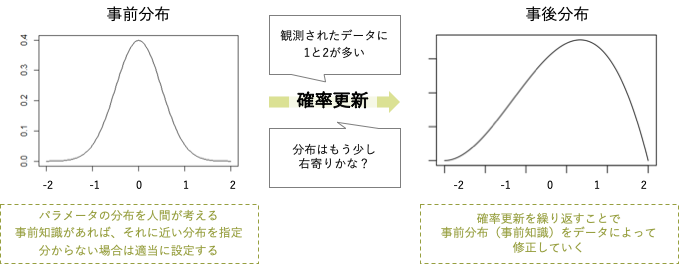

### ベイズの定理
- ここでベイズ統計学で最も重要な定理である「ベイスの定理」を紹介します
- ただし、上述の内容を取り扱い易く数式表現しただけなので、特に新しい情報はありません
- この定理自体は、条件付き確率の式変形から簡単に導出できるので興味ある人は調べてみてください
- 右式の事前分布をデータによって更新して、左式の事後分布を導出している、というイメージだけ最低限つかめれば良いと思います
- ベイズ統計学では基本的にこの定理を利用して、パラメータθを解析的、あるいは（解析的に解けないときは）乱数シミュレーションや最適化手法を用いて近似値を推論しているだけです

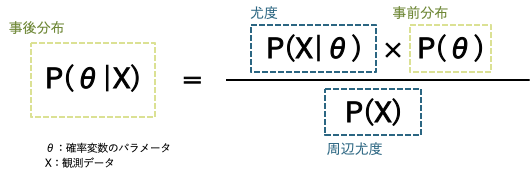

#### 余談）ベイズの定理を機械学習で登場する用語から解釈
- 以下、余談ですので、興味ない方は読み飛ばしてください
    - P(X|θ)は尤度と呼ばれています
    - 機械学習でも登場する**最尤推定法**はこのP(X|θ)を最大化するθを探索します
    - つまり最尤推定法は事前分布を考慮せず、単にP(X|θ)を最大化するθを探索している手続きと捉えることができます
    - これは手元のデータにパラーメータを完全にフィットさせるアプローチなので過学習（オーバーフィット）が発生する原因です
    - また、**MAP推定**というパラーメータ探索法はP(X|θ)×P(θ)を最大化するθを探索します
    - これは、事前分布であるP(θ)という制約条件（正則化）を考慮したパラーメータ探索と捉えることができます
    - 事前分布も考慮しているため、最尤推定ほど手元のデータにオーバーフィットしませんが、事前分布の確率密度関数を計算する必要があるので計算が複雑になります
    - ベイズの定理ではMAP推定に更に周辺尤度（データが平均的に得られる確率）を考慮して事後確率を求めています
    
    
 ## 計算方法
 - ここでは、パラーメーターの計算方法について説明します
 - 様々な計算方法が存在するのですが、ここでは代表的な3つの方法を紹介します
 1. 自然共役事前分布
     - 確率分布のなかには事前分布と事後分布が同じになる組み合わせがあります（例：ベルヌーイ分布とベータ分布）
     - その特性を活かして解析的にパラメータを計算する方法です
     - ただし、その組み合わせ条件を満たすには分布は非常に限定的であるため、現在、実務面で利用されることはあまりないです
     - コンピュータが発達した現代では以下の乱数シミュレーションや最適化を用いた近似値推論が主要な解法となります
 2. MCMC
     - 正式名称はマルコフ連鎖モンテカルロ法と呼ばれる手法です（要は、シミュレーションにより"乱数"を生成する手法です）
     - ただしMCMCでは事後分布に従う乱数を生成することができ、これにより複雑な積分計算を回避することができます
     - MCMCの中にも様々なアルゴリズムが存在します（例：ギブスサンプリング、M-Hアルゴリズム）
     - pythonでは**pyMC**を利用することで実行できます
 3. 変分推論
     - 事後分布に近似する分布を勾配法によって探索する方法です
     - 近似分布と事後分布のロス関数（距離）をKLダイバージェンスで定義し、ロス関数を最小化することで近似値を探索します（ニューラルネットークでよく利用されるアプローチですね）
     - pythonでは**pyro**を利用することで実行できます
     
- 本記事では、MCMCによるパラーメータ推定を紹介します

## デモ　〜線形回帰モデル〜
- 文章では分かりづらいので、早速、pythonでやってみようと思います
- ここでは非常に単純な線形回帰モデルをベイズ統計学で解いてみます
- 正直、この問題であればベイズ統計である必要はないのですが、同様のアプローチで複雑なモデルも解いていくことができます
- まず、今回のデモで利用するサンプルデータを作ります

### サンプルデータの作成

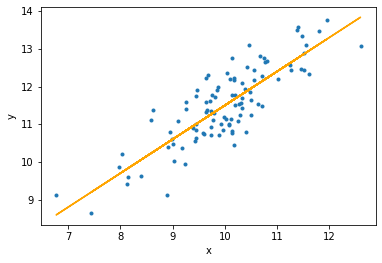

In [12]:
# サンプルデータの作成
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

# サンプルデータ生成のパラメーター
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

# モデル: y = α + βx + Noise
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real *x
y = y_real + eps_real

# データの可視化
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y_real, 'orange')
plt.show()

- 問題設定としては、データ（青点）が与えられたときに、線形モデル（オレンジ線）を推定したい、となります
- 線形モデルは y = α + β*xで定義しており、α=2.5、β=0.9がベイズ統計を用いて推論したい値です（本来は知り得ない値です）

### MCMCで線形回帰モデル
- はじめに、pyMCをインストールします
```
conda install pymc3==3.6
```
- 現時点（2020/11時点）の最新バージョンは3.9なのですが、自分の環境では一部機能で不具合があったので、ダウングレードして利用しています
- この辺りは適宜変更しながらインストールしてみて下さい

### pyMCの基本手順
1. モデルの定義＆MCMCの実行
2. 各パラメータの事後分布の確認・評価
3. 事後分布を利用した推論（予測・信頼区間の可視化）

### pyMCによるモデルの記述方法
- pyMCでは以下の様にモデルを記載する必要があります
- 色々と書いていますが、要は、**1.モデル定義、2.尤度計算、3.MCMCの実行**の3ステップです
- [公式ドキュメント](https://docs.pymc.io/)を確認すると他にも色々なオプション（初期値設定や他MCMCアルゴリズム）が紹介されています
- まずは下記の最低限のモデルの記載方法を理解したのち、必要に応じて他オプションを試してみるのが良いでしょう

```python
# PyMCではwith区でモデルを定義
with pm.Model() as model:
    # 1. 事前分布の定義（パラメータとしたい変数を定義）
    '''
    様々な確率分布がpyMCで用意されており、ここでは正規分布を利用
    文字列で分布名、以降に事前分布のパラメータを設定する
    '''
    α = pm.Normal('alpha', mu=0, sd=10)# 正規分布（平均=0, 標準偏差=10)
    β = pm.Normal('beta', mu=0, sd=1)# 正規分布（平均=0, 標準偏差=1)
    noise = pm.Normal('noise', mu=0, sd=1)
    # 2. 尤度の計算
    '''
    observedに観測値を与えることで確率更新が行われる
    '''
     y_pred = pm.Normal('y_pred', mu=α*x+β, sd=noise, observed=y)
    # 3. MCMCの実行
    '''
    初期値やアルゴリズムなど様々な設定があるが、基本的かつ汎用的な"NUTS"というアルゴリズムを利用
    draws=生成する乱数の数, chains=並列処理数
    '''
    trace = pm.sample(draws=5000, chains=1) # 5000サンプル*1並列=5000の乱数を生成
```

In [29]:
import pymc3 as pm    
    
# モデル
with pm.Model() as model:
    # 1. 事前分布
    alpha = pm.Normal('alpha', mu=0, sd=10)# αには平均0, 標準偏差10の正規分布を仮定
    beta = pm.Normal('beta', mu=0, sd=1)# βには平均0, 標準偏差1の正規分布を仮定
    epsilon = pm.HalfCauchy('epcilon', 5)#  noiseには最頻値5の半コーシー分布を仮定
    # 2. 尤度の計算
    y_pred = pm.Normal('y_pred', mu=alpha+beta*x, sd=epsilon, observed=y)
    # 3. MCMCの実行
    trace = pm.sample(11000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [epcilon, beta, alpha]
100%|██████████| 11500/11500 [00:32<00:00, 352.40it/s]
The acceptance probability does not match the target. It is 0.8822139879973696, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<AxesSubplot:title={'center':'alpha'}, ylabel='Frequency'>,
        <AxesSubplot:title={'center':'alpha'}, ylabel='Sample value'>],
       [<AxesSubplot:title={'center':'beta'}, ylabel='Frequency'>,
        <AxesSubplot:title={'center':'beta'}, ylabel='Sample value'>],
       [<AxesSubplot:title={'center':'epcilon'}, ylabel='Frequency'>,
        <AxesSubplot:title={'center':'epcilon'}, ylabel='Sample value'>]],
      dtype=object)

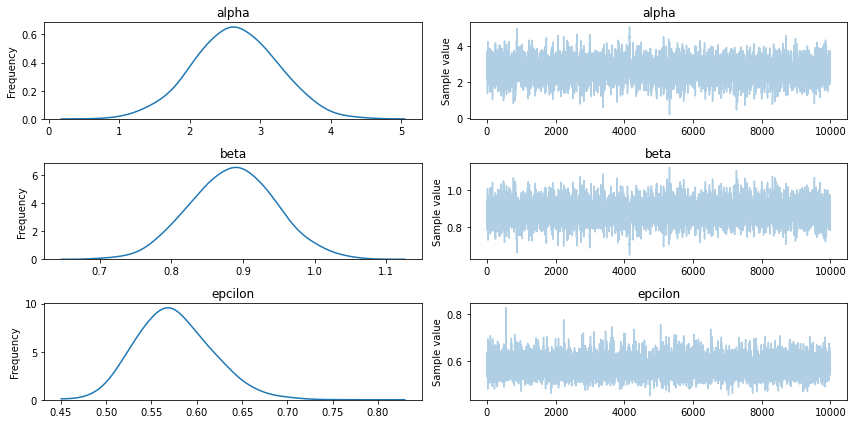

In [30]:
# 各パラメータの事後分布の確認・評価（グラフ）
trace_n = trace[1000:]# 初めの1000件を捨てる（後述："バーン・イン"）
pm.traceplot(trace_n)

In [31]:
# 各パラメータの事後分布の確認・評価（統計量）
pm.summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.648258,0.595553,0.010432,1.438280,3.768594
beta,0.886561,0.059414,0.001034,0.773619,1.005064
epcilon,0.575935,0.041416,0.000658,0.499929,0.659088


- 出力結果の見方
    - グラフ（左列）が各パラメータの分布（確率密度関数）になっています
    - α=約2.64, β=約0.88が中心の分布となっており、正解（α=2.5、β=0.9）と近しいパラメーターの推定が行えていることが分かります
    - グラフ（右列）は乱数シミュレーションの収束状況を表しており、今回は定常分布へ収束していますが、ここが上手く収束しない場合は事前分布やそのパラメータ、特徴量の標準化等の前処理を行う必要があります

-  バーン・イン
    - MCMCでは目標分布からサンプルを得るのにしばらく時間がかかるので、サンプル生成初期のデータは利用しない方が良いとされています
    - そこで、生成されたサンプルの最初の1000サンプルを除いてパラメータの事後分布の評価を行なっています

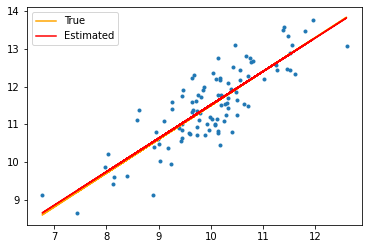

In [28]:
# α, βの値の取得（シミュレーション結果の平均値を各パラメータの代表値とする）
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()

# 可視化
plt.plot(x, y, '.')
plt.plot(x, y_real, 'orange', label='True')
plt.plot(x, alpha_m + beta_m*x, 'red', label='Estimated')
plt.legend()

- 線形モデルのプロット
    - 事後分布のシミュレーション結果の**平均値**をパラメータの代表値として回帰直線を引いています
    - "サンプルデータの作成"でプロットした正解の回帰直線と同様の直線が描けていることが分かります

In [33]:
# 事後分布からのサンプル生成
ppc = pm.sample_posterior_predictive(trace_n, samples=1000, model=model)

100%|██████████| 1000/1000 [00:00<00:00, 1914.74it/s]


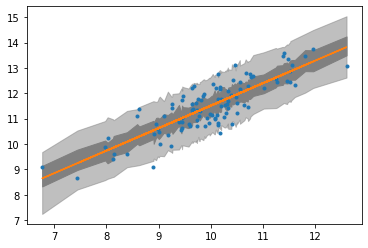

In [35]:
# 散布図と回帰直線の可視化
plt.plot(x, y, '.')
plt.plot(x, alpha_m + beta_m*x)

# 信頼区間
idx = np.argsort(x)
x_ord = x[idx]
# 50%HPD区間
sig0 = pm.stats.hpd(ppc['y_pred'], alpha=0.5)[idx]
# 95%HPD区間
sig1 = pm.stats.hpd(ppc['y_pred'], alpha=0.05)[idx]
# 信頼区間を塗りつぶしで表現
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

- ベイズモデル（MCMC）では、事後分布の乱数シミュレーションの結果を持つことができます
- これにより50%, 95%に信頼区間を表現することができます
- ベイズモデルではHPD区間（パラメータが取り得る値）を利用することが多いです

#### HPD区間とは
- 最高事後密度信用区間とも呼ばれる
- 分布形状によらず必ずパラメータの最頻値が含まれるように設定される信頼区間幅
- 数式でみると複雑ですがが、絵（グラフ）で確認すると非常に当たり前の定義です
- こちらの[サイト](https://ai-trend.jp/basic-study/bayes/bayes_interval_estimation/)が解説が分かりやすいです

## さいごに
### ベイズモデリングの可能性
- 本記事では、ベイズ統計学の基礎と線形回帰モデルをMCMCを用いて解いてみました
-  **ベイズモデリングの特徴として、推定結果が1つの値であなく、確率分布を持って表現できることが特徴**です
- 意思決定の際は、**予測結果だけでなく、そのばらつき（信頼度）もセットに考慮する必要がある**ので非常に実務的かと思います
- 今回は簡単のため事前分布は全て正規分布を仮定しましたが、pyMCでは様々な確率分布がサポートされており、事前知識に則った分布を設定することができます
- また、線形回帰モデルだけでなく、リンク関数を変更するだけでロジスティック回帰モデルをベイジアンモデルで解いたり、推定結果の信頼度を可視化したりと、同様のアプローチで様々な問題に取り組むことができます
- この意味で**ベイズモデリングは非常に自由度の高く、汎用性の高いモデリング手法**であると言えます
- 一方で、（上記を実行いただくと分かるのですが）MCMCはモデルが複雑になるとシミュレーションに時間がかかります
- その場合は、変分推論による最適化手法で解くこともできます（pythonライブラリpyroによる変分推論による解法も説明しようと思ったのですが、記事分量が多くなってしまったので別記事で作成しようと思います）

### データ活用の推進に向けて
- 今回の記事ではベイズ統計学の基礎の基礎を昨今、実務で最も利用される言語の一つであるpythonを用いて解説してみました
- DXやデータ活用が叫ばれる現代において、「取り組みを推進したいが適切なデータがない!!」という悩みをよく聞きます
- 一からデータベースを構築してデータ収集を開始することは当然重要ですが、それだけではデータ活用の取組みが先行するグローバルの企業達には追いつけないでしょう
- そこで、**データは無いが長年培ってきた業務に関するノウハウが豊富な日本企業**にこそベイズモデリングは活かせるのでは、と思い本記事を書いてみました
- データ活用を推進したいが上手く進められていない事業者の少しのヒントになれば幸いです